# Import Library

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
customer = pd.read_excel("Customer.xlsx")
product = pd.read_excel("Product.xlsx")
store = pd.read_excel("Store.xlsx")
transaction = pd.read_excel("Transaction.xlsx")

In [3]:
print("Customer :", customer.shape)
print("product :", product.shape)
print("store :", store.shape)
print("transaction ;", transaction.shape)

Customer : (447, 5)
product : (10, 3)
store : (14, 6)
transaction ; (5020, 8)


 # Basic EDA & Data Preprocessing

In [118]:
customer.head()

,CustomerID,Age,Gender,Marital Status,Income
0,1,55,1,Married,5.12
1,2,60,1,Married,6.23
2,3,32,1,Married,9.17
3,4,31,1,Married,4.87
4,5,58,1,Married,3.57


In [119]:
product.head()

,ProductID,Product Name,Price
0,P1,Choco Bar,8800
1,P2,Ginger Candy,3200
2,P3,Crackers,7500
3,P4,Potato Chip,12000
4,P5,Thai Tea,4200


In [41]:
store.head()

,StoreID,StoreName,GroupStore,Type,Latitude,Longitude
0,1,Prima Tendean,Prima,Modern Trade,-6.200000,106.816666
1,2,Prima Kelapa Dua,Prima,Modern Trade,-6.914864,107.608238
2,3,Prima Kota,Prima,Modern Trade,-7.797068,110.370529
3,4,Gita Ginara,Gita,General Trade,-6.966667,110.416664
4,5,Bonafid,Gita,General Trade,-7.250445,112.768845


In [42]:
transaction.head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID
0,TR11369,328,2022-01-01,P3,7500,4,30000,12
1,TR16356,165,2022-01-01,P9,10000,7,70000,1
2,TR1984,183,2022-01-01,P1,8800,4,35200,4
3,TR35256,160,2022-01-01,P1,8800,7,61600,4
4,TR41231,386,2022-01-01,P9,10000,1,10000,4


In [43]:
customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447 entries, 0 to 446
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CustomerID      447 non-null    int64  
 1   Age             447 non-null    int64  
 2   Gender          447 non-null    int64  
 3   Marital Status  444 non-null    object 
 4   Income          447 non-null    float64
dtypes: float64(1), int64(3), object(1)
memory usage: 17.6+ KB


In [3]:
customer = customer.dropna(inplace= False)

In [121]:
product.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ProductID     10 non-null     object
 1   Product Name  10 non-null     object
 2   Price         10 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 368.0+ bytes


In [47]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   StoreID     14 non-null     int64  
 1   StoreName   14 non-null     object 
 2   GroupStore  14 non-null     object 
 3   Type        14 non-null     object 
 4   Latitude    14 non-null     float64
 5   Longitude   14 non-null     float64
dtypes: float64(2), int64(1), object(3)
memory usage: 800.0+ bytes


##### checking for quasi constants

* karena saya memasukan datasetnya dalam bentuk excel agar dataset awalnya berbentuk csv ; sehingga tidak dapat di load.
* oleh karena itu saya merubah format terlebih dahulu menjadi excel.
* akibat data yang saya masukan dalam bentuk excel data menjadi secara otomatis typenya sudah benar  sehingga tidak perlu banyakk melakuan measing value dan cleansing.

In [4]:
# Merge DataFrame berdasarkan kolom 'ID'
merged_df = pd.merge(customer, transaction, on='CustomerID')
merged_df = pd.merge(merged_df, store , on='StoreID')
merged_df = pd.merge(merged_df, product.drop(columns =['Price']), on='ProductID')
merged_df

,CustomerID,Age,Gender,Marital Status,Income,TransactionID,Date,ProductID,Price,Qty,TotalAmount,StoreID,StoreName,GroupStore,Type,Latitude,Longitude,Product Name
0,1,55,1,Married,5.12,TR54475,2022-02-23,P8,16000,1,16000,9,Lingga,Lingga,Modern Trade,-3.654703,128.190643,Oat
1,5,58,1,Married,3.57,TR53643,2022-05-22,P8,16000,3,48000,9,Lingga,Lingga,Modern Trade,-3.654703,128.190643,Oat
2,7,31,0,Married,4.57,TR5151,2022-03-10,P8,16000,2,32000,9,Lingga,Lingga,Modern Trade,-3.654703,128.190643,Oat
3,19,24,1,Single,4.14,TR98635,2022-06-18,P8,16000,1,16000,9,Lingga,Lingga,Modern Trade,-3.654703,128.190643,Oat
4,28,55,0,Married,6.08,TR9420,2022-01-12,P8,16000,3,48000,9,Lingga,Lingga,Modern Trade,-3.654703,128.190643,Oat
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4971,380,40,0,Married,5.77,TR61763,2022-07-02,P9,10000,3,30000,10,Harapan Baru,Harapan Baru,General Trade,3.597031,98.678513,Yoghurt
4972,385,41,1,Married,15.84,TR91332,2022-01-09,P9,10000,1,10000,10,Harapan Baru,Harapan Baru,General Trade,3.597031,98.678513,Yoghurt
4973,408,34,1,Married,9.45,TR18608,2022-11-06,P9,10000,7,70000,10,Harapan Baru,Harapan Baru,General Trade,3.597031,98.678513,Yoghurt
4974,412,18,1,Single,0.00,TR10192,2022-11-21,P9,10000,6,60000,10,Harapan Baru,Harapan Baru,General Trade,3.597031,98.678513,Yoghurt


In [158]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4976 entries, 0 to 4975
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   CustomerID      4976 non-null   int64         
 1   Age             4976 non-null   int64         
 2   Gender          4976 non-null   int64         
 3   Marital Status  4976 non-null   object        
 4   Income          4976 non-null   float64       
 5   TransactionID   4976 non-null   object        
 6   Date            4976 non-null   datetime64[ns]
 7   ProductID       4976 non-null   object        
 8   Price           4976 non-null   int64         
 9   Qty             4976 non-null   int64         
 10  TotalAmount     4976 non-null   int64         
 11  StoreID         4976 non-null   int64         
 12  StoreName       4976 non-null   object        
 13  GroupStore      4976 non-null   object        
 14  Type            4976 non-null   object        
 15  Lati

# Time Series

In [5]:
df_regresi = merged_df.groupby(['Date']).agg({ 'Qty' : 'sum'}).reset_index()
df_regresi

,Date,Qty
0,2022-01-01,49
1,2022-01-02,59
2,2022-01-03,63
3,2022-01-04,45
4,2022-01-05,28
...,...,...
360,2022-12-27,70
361,2022-12-28,68
362,2022-12-29,42
363,2022-12-30,40


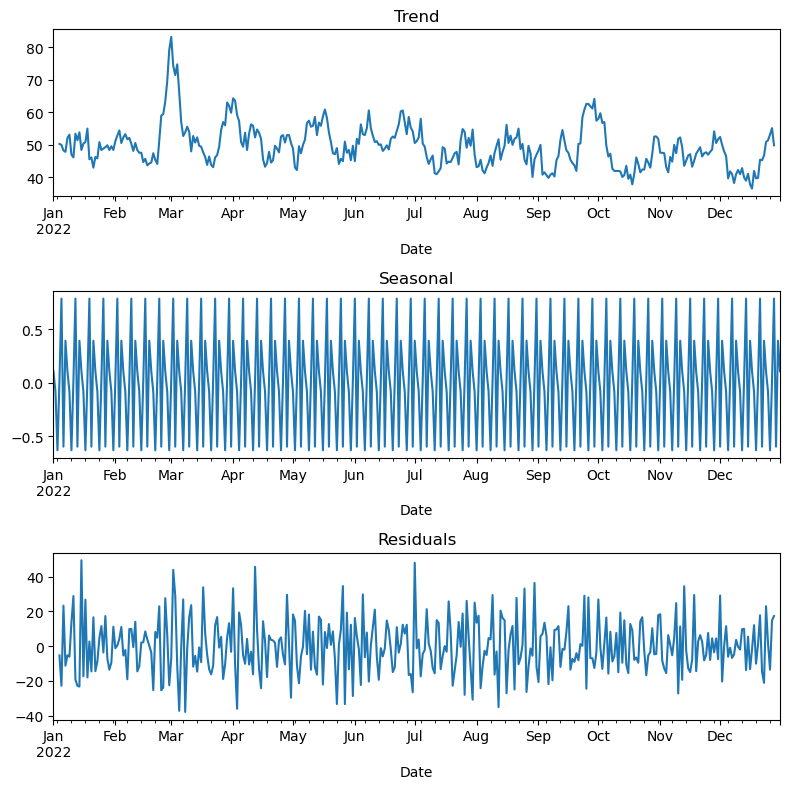

In [6]:
# Decomposisi
decomposed = seasonal_decompose(df_regresi.set_index('Date'))
plt.figure(figsize=(8, 8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonal')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()
plt.show()

In [11]:
def rmse(y_actual, y_pred):
    '''
    function to calculate rmse
    '''
    print(f'RMSE value (mean_squared_error(y_actual, y_pred)**0.5))')
    
def eval(y_actual, y_pred):
    '''
    function to eval machine learning model
    '''
    
    rmse(y_actual, y_pred)
    print(f'MAE Value (mean_absolute_error(y_actual, y_pred)')

In [7]:
# Memisahkan data menjadi data latih dan data uji
train_size = int(len(df_regresi) * 0.9)
train_df, test_df = df_regresi[:train_size], df_regresi[train_size:]

In [8]:
# Menetapkan kolom 'Date' sebagai indeks untuk data latih dan data uji
train_df = train_df.set_index('Date')
test_df = test_df.set_index('Date')

In [9]:
# Memisahkan target 'Qty' dari data latih
y = train_df['Qty']

C:\Users\WINARDI\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\WINARDI\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\WINARDI\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\WINARDI\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\WINARDI\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting M

Mean Squared Error (MSE): 205.4500134178513
Mean Absolute Error (MAE): 11.376593253102381


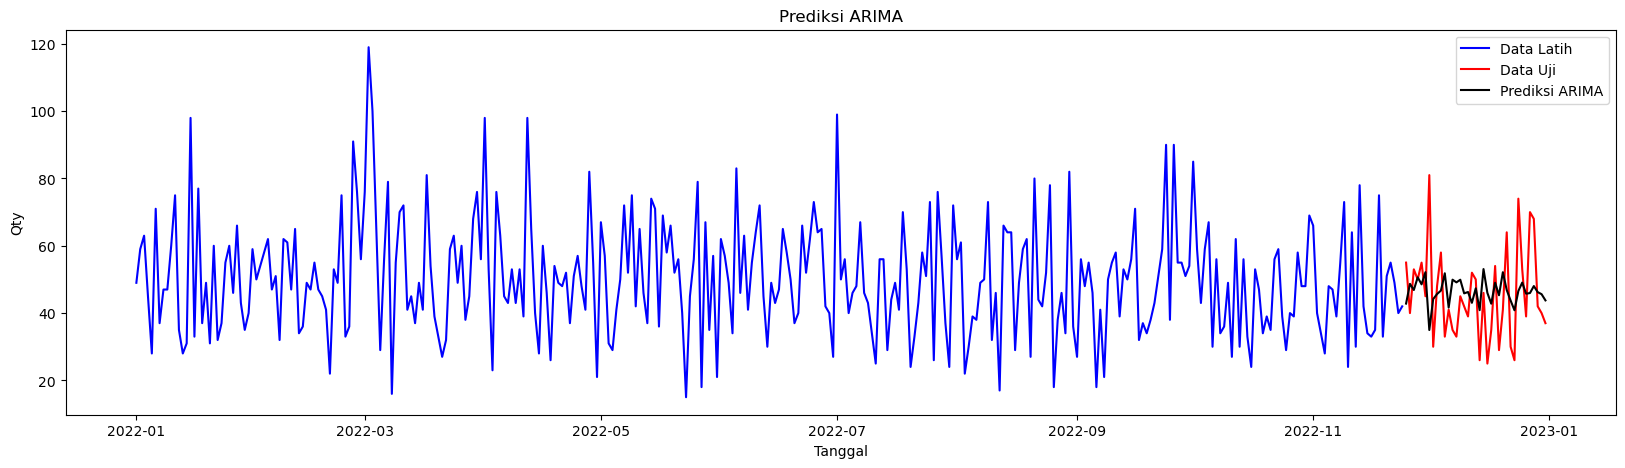

In [12]:
# Membangun model ARIMA dengan orde (p, d, q) = (4, 2, 1)
ARIMA_model = ARIMA(y, order=(40, 2, 1))
ARIMA_fit = ARIMA_model.fit()

# Memprediksi data uji
forecast = ARIMA_fit.forecast(steps=len(test_df))

# Mengonversi hasil prediksi menjadi DataFrame
y_pred_df = pd.DataFrame({'Predictions': forecast}, index=test_df.index)

# Evaluasi model menggunakan metrik MSE dan MAE
mse = mean_squared_error(test_df['Qty'], y_pred_df['Predictions'])
mae = mean_absolute_error(test_df['Qty'], y_pred_df['Predictions'])
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')

# Plot hasil prediksi
plt.figure(figsize=(20, 5))
plt.plot(train_df['Qty'], color='blue', label='Data Latih')
plt.plot(test_df['Qty'], color='red', label='Data Uji')
plt.plot(y_pred_df['Predictions'], color='black', label='Prediksi ARIMA')
plt.legend()
plt.title('Prediksi ARIMA')
plt.xlabel('Tanggal')
plt.ylabel('Qty')
plt.show()

# Clustering

In [6]:
# Pilih fiture
cluster = merged_df.groupby(['CustomerID']).agg({ 'TransactionID' : 'count', 
                                                 'Qty' : 'sum',
                                                 'TotalAmount': 'sum' }).reset_index()
x = cluster.iloc[:, [1, 2, 3]].values
label = cluster.iloc[:,0].values
print("Input Data and Shape")
print(cluster.shape)
print(type(x))

Input Data and Shape
(444, 4)
<class 'numpy.ndarray'>


In [9]:
cluster

,CustomerID,TransactionID,Qty,TotalAmount
0,1,17,60,623300
1,2,13,57,392300
2,3,15,56,446200
3,4,10,46,302500
4,5,7,27,268600
...,...,...,...,...
439,442,13,37,269400
440,444,18,62,577700
441,445,18,68,587200
442,446,11,42,423300


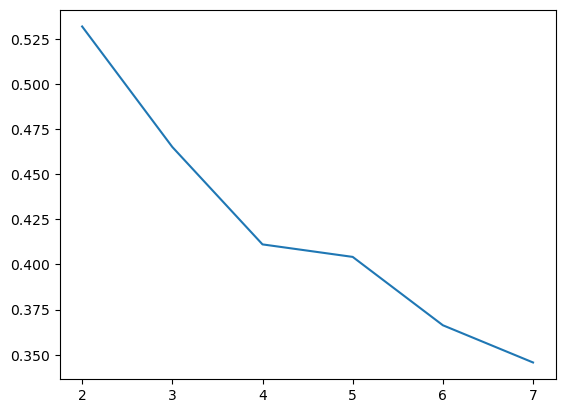

In [12]:
sns.lineplot(x=K, y=score)
plt.show()

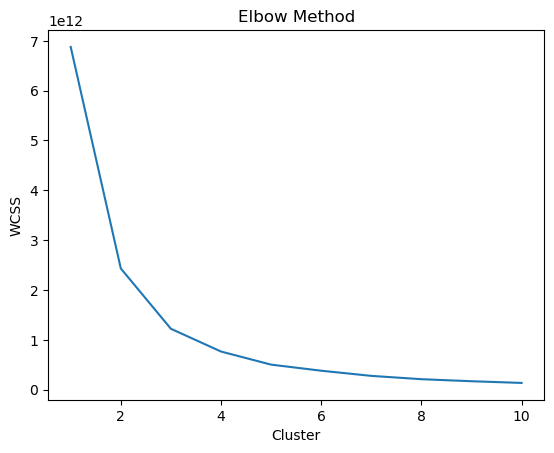

In [7]:
#Finding the optimum number of clusters for k-means classification
from sklearn.cluster import KMeans
wcss = [] # weight list array

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 50, n_init = 10, random_state = 10)
    kmeans.fit(x) # kmeans model
    wcss.append(kmeans.inertia_) # append kmeans weight 
    
#Plotting the results onto a line graph, allowing us to observe 'The elbow'
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Cluster')
plt.ylabel('WCSS') #within cluster sum of squares
plt.show()

In [8]:
#Applying kmeans to the dataset / Creating the kmeans classifier
kmeans = KMeans(n_clusters = 5, init = 'k-means++', max_iter = 300, n_init = 20, random_state = 0)
y_kmeans = kmeans.fit_predict(x)
# output = y_kmeans.predict(x)
# print(output)
# y_kmeans.head()
dataframe = pd.DataFrame({"CustomerID":label,  "Cluster":y_kmeans})
dataframe

,CustomerID,Cluster
0,1,2
1,2,4
2,3,0
3,4,3
4,5,3
...,...,...
439,442,3
440,444,2
441,445,2
442,446,4


In [9]:
cluster_Predict = pd.merge(dataframe, cluster, on='CustomerID')

In [10]:
cluster_Predict

,CustomerID,Cluster,TransactionID,Qty,TotalAmount
0,1,2,17,60,623300
1,2,4,13,57,392300
2,3,0,15,56,446200
3,4,3,10,46,302500
4,5,3,7,27,268600
...,...,...,...,...,...
439,442,3,13,37,269400
440,444,2,18,62,577700
441,445,2,18,68,587200
442,446,4,11,42,423300


In [11]:
cluster_Predict = cluster_Predict.drop(columns=['CustomerID'])
cluster_Predict= cluster_Predict.groupby(['Cluster']).agg({ 'TransactionID' : 'count', 
                                                 'Qty' : 'sum',
                                                 'TotalAmount': 'sum' }).reset_index()
cluster_Predict

,Cluster,TransactionID,Qty,TotalAmount
0,0,82,4310,39379100
1,1,73,1732,13953300
2,2,38,2387,23249100
3,3,127,4425,36691200
4,4,124,5271,47296000


* Dari hasil elbow method yang diperoleh dipilih 5 cluster, karena pada nilai 5 garfik menuju landai
* dari cluster yang didapat diketahui bahwa :
    - untuk kluster 1 jumlah transaksi-nya kedua palling sedikit. Qty Produk dan totalamount paling sedikit, oleh karena untuk tipe customer seperti ini dapat dipromosikan dengan poin belanja agar meningkatkan jumlah transaksi.
    - untuk klustere dengan jumlah transaksi terbanyak kedua, jumlah qty terbanyak, dan total amount terbanyak dapat diberikan pelayanan prioritas seperti kecepatan pengiriman atua memberikan give away juka mencapai jumlah taransaksi tertentu.
    - untuk kluster 2 dimana jumlah transaksinya paling sedikit dapat diberikan promosi dalam kurun waktu tertentu aagak meningkat jumlah transaksinya.
